In [8]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git

  Preparing metadata (setup.py) ... done


In [9]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [3]:
# download model and data
!wget -O img_demo.png https://raw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2025-01-20 20:10:45--  https://raw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87865 (86K) [image/png]
Saving to: ‘img_demo.png’

img_demo.png        100%[===================>]  85.81K  --.-KB/s    in 0.01s   

2025-01-20 20:10:46 (5.86 MB/s) - ‘img_demo.png’ saved [87865/87865]

--2025-01-20 20:10:46--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: ‘medsam_vit_b.pth’

medsam_vit_b.pth    100%[===================

In [2]:
#%% load model and image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

img_np = io.imread('img_demo.png')
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.device

In [3]:
#%% image preprocessing and model inference
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

box_np = np.array([[95,255, 190, 350]])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

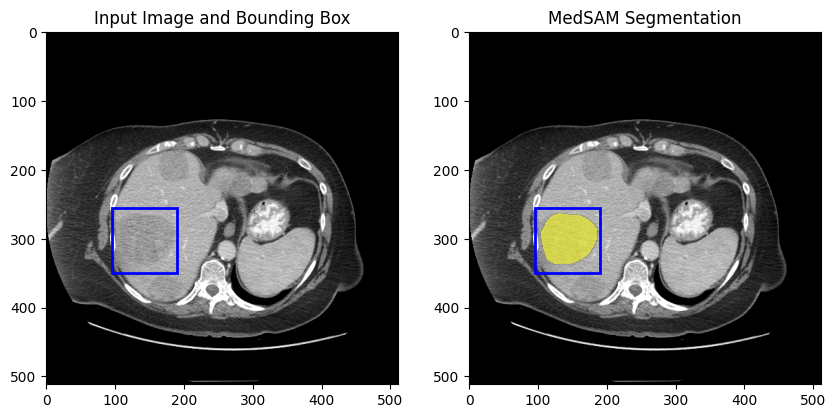

In [6]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

Calculated bounding box coordinates from maskco.png:
Top-left: (Row: 128, Column: 125)
Bottom-right: (Row: 310, Column: 327)


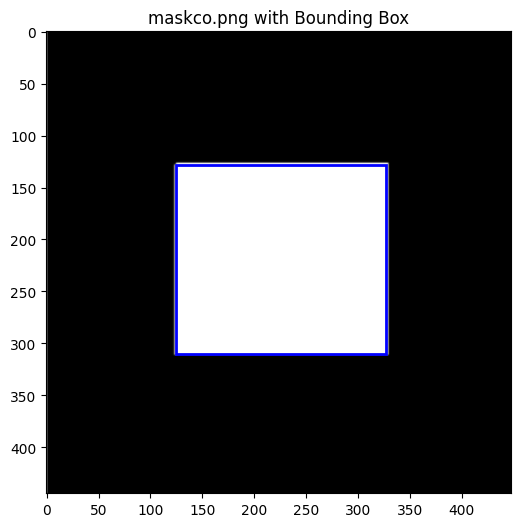

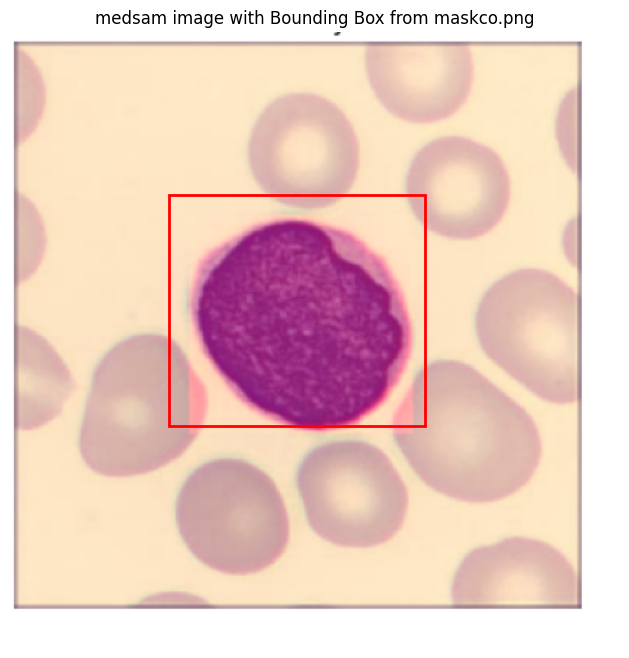

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.device

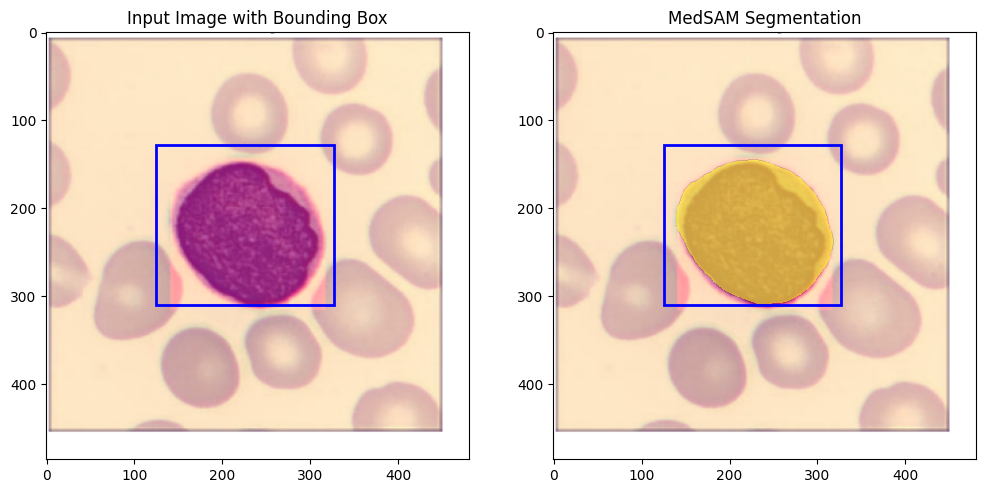

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from skimage import io, transform
import torch.nn.functional as F
from segment_anything import sam_model_registry

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax, edgecolor='blue'):
    # Box format: [x0, y0, x1, y1]
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=edgecolor, facecolor=(0, 0, 0, 0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # shape: (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )

    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )
    low_res_pred = torch.sigmoid(low_res_logits)  # shape: (1, 1, 256, 256)
    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # upsample to original image size
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

# %% Part 1: Calculate Bounding Box from maskco.png
# Update the mask image path if needed.
mask_image_path = "/content/maskco.png"
mask_image = Image.open(mask_image_path).convert("L")  # convert to grayscale
mask_array = np.array(mask_image)

# Identify white pixels (assumed to be 255)
white_coords = np.argwhere(mask_array == 255)
# Optionally exclude border pixels (if necessary)
inner_white_coords = white_coords[(white_coords[:, 0] > 0) & (white_coords[:, 1] > 0)]

# Compute the bounding box from the white region
inner_min_row, inner_min_col = inner_white_coords.min(axis=0)
inner_max_row, inner_max_col = inner_white_coords.max(axis=0)

print("Calculated bounding box coordinates from maskco.png:")
print(f"Top-left: (Row: {inner_min_row}, Column: {inner_min_col})")
print(f"Bottom-right: (Row: {inner_max_row}, Column: {inner_max_col})")

# Visualize mask image with bounding box
plt.figure(figsize=(6, 6))
plt.imshow(mask_array, cmap="gray")
rect = plt.Rectangle((inner_min_col, inner_min_row),
                     inner_max_col - inner_min_col,
                     inner_max_row - inner_min_row,
                     edgecolor='blue', facecolor='none', linewidth=2)
plt.gca().add_patch(rect)
plt.title("maskco.png with Bounding Box")
plt.axis("on")
plt.show()


img_path = "medsam.png"   
img_np = io.imread(img_path)

# Ensure image is three-channel (RGB). Remove alpha if present.
if img_np.ndim == 3:
    if img_np.shape[2] == 4:
        # Remove the alpha channel (RGBA -> RGB)
        img_3c = img_np[..., :3]
    else:
        img_3c = img_np
else:
    # If the image is grayscale, repeat channels to convert to RGB.
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)

H, W, _ = img_3c.shape

# Visualize medsam image with bounding box extracted from maskco.png
plt.figure(figsize=(8, 8))
plt.imshow(img_3c)
plt.gca().add_patch(plt.Rectangle((inner_min_col, inner_min_row),
                     inner_max_col - inner_min_col,
                     inner_max_row - inner_min_row,
                     edgecolor='red', facecolor='none', linewidth=2))
plt.title("medsam image with Bounding Box from maskco.png")
plt.axis("off")
plt.show()

# %% Load MedSAM model and Prepare the Image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"  
device = "cuda:0" 

medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

# Resize the image to 1024x1024 pixels (MedSAM requirement)
img_1024 = transform.resize(img_3c, (1024, 1024), order=3,
                            preserve_range=True, anti_aliasing=True).astype(np.uint8)

# Normalize image to [0,1]
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)
# Convert to tensor (shape: [1, 3, 1024, 1024])
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

# Generate image embedding
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # Expected shape: (1, 256, 64, 64)


box_np = np.array([[inner_min_col, inner_min_row, inner_max_col, inner_max_row]])
# Scale bounding box from original image size (W, H) to 1024x1024
box_1024 = box_np / np.array([W, H, W, H]) * 1024

# %% Run MedSAM Segmentation Inference Using the Bounding Box
medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

# %% Visualize the Results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Left: Input image with bounding box (original scale)
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0], edgecolor='blue')
ax[0].set_title("Input Image with Bounding Box")

# Right: Input image with segmentation mask overlay
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1], edgecolor='blue')
ax[1].set_title("MedSAM Segmentation")
plt.show()


Calculated bounding box coordinates from maskco.png:
Top-left: (Row: 128, Column: 125)
Bottom-right: (Row: 310, Column: 327)


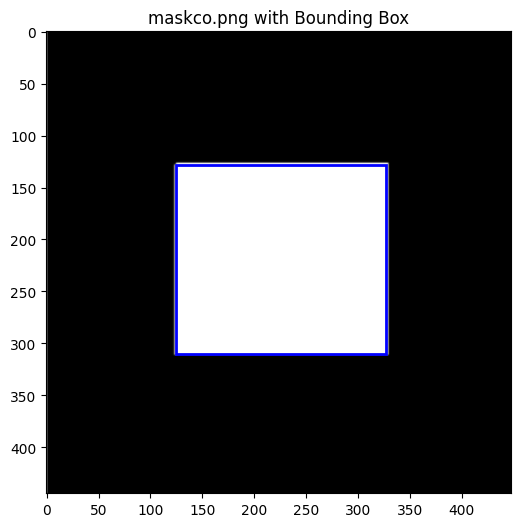

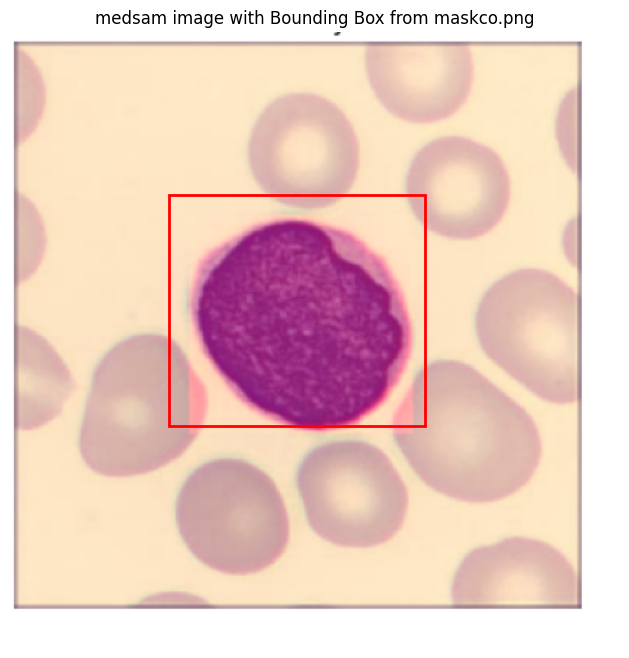

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.device

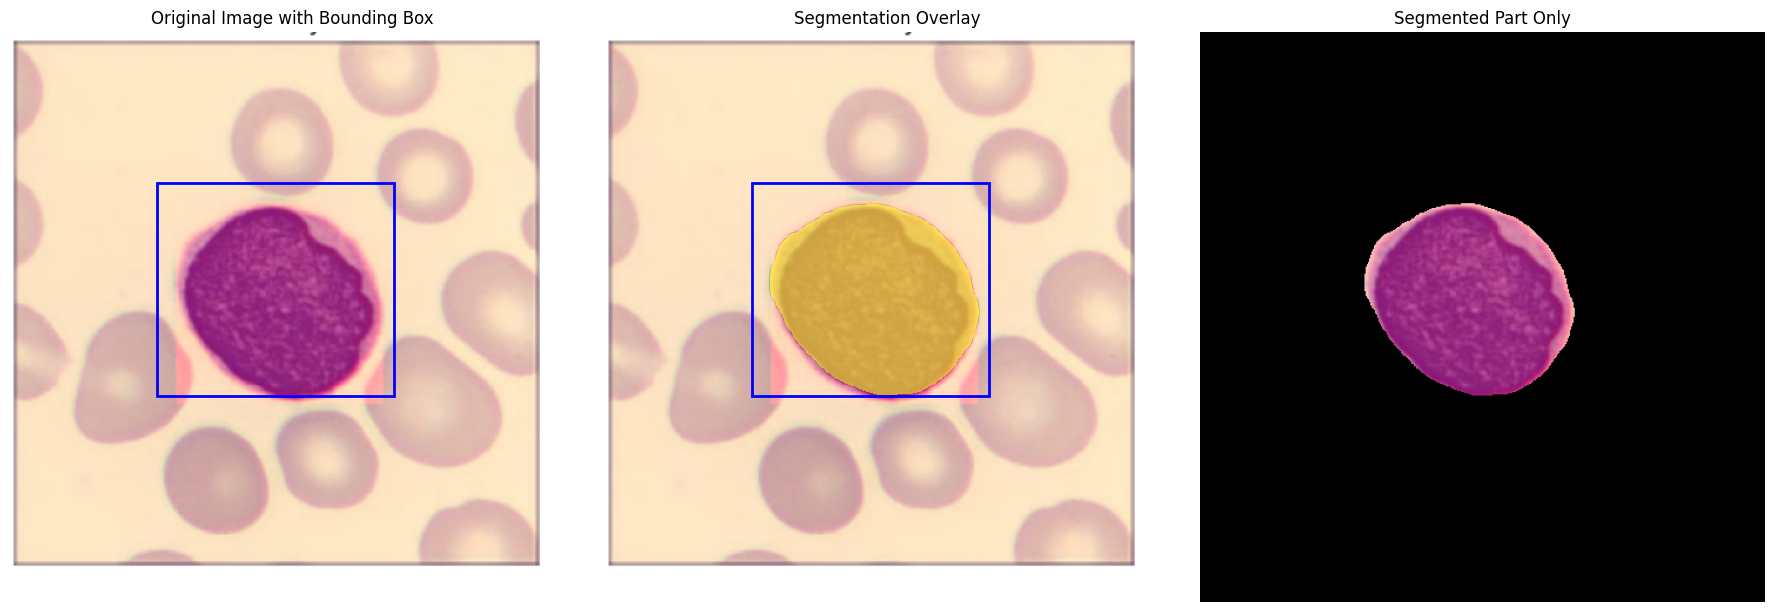

In [13]:
# %% Imports and Utility Functions
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from skimage import io, transform
import torch.nn.functional as F
from segment_anything import sam_model_registry

# Visualization function for segmentation mask overlay.
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax, edgecolor='blue'):
    # Box format: [x0, y0, x1, y1]
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h,
                 edgecolor=edgecolor, facecolor=(0, 0, 0, 0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    # Prepare bounding box prompt.
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # shape (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )

    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )
    low_res_pred = torch.sigmoid(low_res_logits)  # shape: (1, 1, 256, 256)
    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

# %% Part 1: Calculate Bounding Box from maskco.png
mask_image_path = "/content/maskco.png"  # Update this path if needed.
mask_image = Image.open(mask_image_path).convert("L")  # Convert mask to grayscale.
mask_array = np.array(mask_image)

# Identify white pixels (value 255).
white_coords = np.argwhere(mask_array == 255)
# Optionally, exclude border pixels.
inner_white_coords = white_coords[(white_coords[:, 0] > 0) & (white_coords[:, 1] > 0)]
# Compute bounding box: (min_row, min_col) to (max_row, max_col)
inner_min_row, inner_min_col = inner_white_coords.min(axis=0)
inner_max_row, inner_max_col = inner_white_coords.max(axis=0)

print("Calculated bounding box coordinates from maskco.png:")
print(f"Top-left: (Row: {inner_min_row}, Column: {inner_min_col})")
print(f"Bottom-right: (Row: {inner_max_row}, Column: {inner_max_col})")

# Visualize the mask with the bounding box.
plt.figure(figsize=(6, 6))
plt.imshow(mask_array, cmap="gray")
rect = plt.Rectangle((inner_min_col, inner_min_row),
                     inner_max_col - inner_min_col,
                     inner_max_row - inner_min_row,
                     edgecolor='blue', facecolor='none', linewidth=2)
plt.gca().add_patch(rect)
plt.title("maskco.png with Bounding Box")
plt.axis("on")
plt.show()


img_path = "medsam.png"  
img_np = io.imread(img_path)

# Ensure image is three-channel (RGB). Remove the alpha channel if present.
if img_np.ndim == 3:
    if img_np.shape[2] == 4:
        img_3c = img_np[..., :3]
    else:
        img_3c = img_np
else:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)

H, W, _ = img_3c.shape

# Visualize medsam image with the bounding box extracted from maskco.png.
plt.figure(figsize=(8, 8))
plt.imshow(img_3c)
plt.gca().add_patch(plt.Rectangle((inner_min_col, inner_min_row),
                     inner_max_col - inner_min_col,
                     inner_max_row - inner_min_row,
                     edgecolor='red', facecolor='none', linewidth=2))
plt.title("medsam image with Bounding Box from maskco.png")
plt.axis("off")
plt.show()

# %% Load MedSAM Model and Prepare the Image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"  # Update checkpoint path as needed.
device = "cuda:0"  # Change to "cpu" if GPU is not available.

# Instantiate the model (ensure 'vit_b' is correct for your model).
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

# Resize image to 1024x1024 (MedSAM requirement) and normalize.
img_1024 = transform.resize(img_3c, (1024, 1024), order=3,
                            preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)
# Convert to tensor with shape [1, 3, 1024, 1024].
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

# Generate image embedding
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

box_np = np.array([[inner_min_col, inner_min_row, inner_max_col, inner_max_row]])
# Scale bounding box from original image size (W, H) to 1024x1024.
box_1024 = box_np / np.array([W, H, W, H]) * 1024

# %% Run MedSAM Segmentation Inference Using the Bounding Box
medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

segmented_part = (img_3c * medsam_seg[..., None]).astype(np.uint8)

# %% Visualize the Results: Original, Segmentation Overlay, and Segmented Part Only
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Left: Original image with bounding box.
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0], edgecolor='blue')
ax[0].set_title("Original Image with Bounding Box")
ax[0].axis("off")

# Middle: Original image with segmentation overlay.
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1], edgecolor='blue')
ax[1].set_title("Segmentation Overlay")
ax[1].axis("off")

# Right: Segmented part only.
ax[2].imshow(segmented_part)
ax[2].set_title("Segmented Part Only")
ax[2].axis("off")

plt.tight_layout()
plt.show()
